In [1]:
import numpy as np
np.set_printoptions(linewidth=200, precision=4) # to print wide matrices

import simphony
simphony.Config.set_platform('gpu')
simphony.Config.set_matplotlib_format('retina')
import jax.numpy as jnp
from matplotlib import pyplot as plt

In [6]:
def Hahn_echo(model, wait, f_ac_mhz, B_ac_tesla, apply_noise=False, n_shots=1):
        
    duration = 0.01  
    
    frequency = model.splitting_qubit('e', rest_quantum_nums={'N': 0})
    
    angle1 = np.pi / 2
    period_time1 = 2 * np.pi * duration / angle1
    angle2 = np.pi
    period_time2 = 2 * np.pi * duration / angle2
    
    amplitude1 = model.rabi_cycle_amplitude_qubit(
        driving_field_name='MW_x',
        period_time=period_time1,
        spin_name='e'
    )
    amplitude2 = model.rabi_cycle_amplitude_qubit(
        driving_field_name='MW_x',
        period_time=period_time2,
        spin_name='e'
    )
    
    complete_pulse_time = wait*2 +duration
    model.remove_all_pulses()
    model.driving_field('Outside_field').add_wait(duration)
    model.driving_field('Outside_field').add_rectangle_pulse(amplitude=B_ac_tesla,
                                                             frequency=f_ac_mhz,
                                                             phase=np.pi/2,
                                                             duration=complete_pulse_time)
    model.driving_field('MW_x').add_rectangle_pulse(
        amplitude=amplitude1,
        frequency=frequency,
        phase=0,
        duration=duration
    )
    
    model.driving_field('MW_x').add_wait(wait)
    model.driving_field('MW_x').add_rectangle_pulse(
        amplitude=amplitude2,
        frequency=frequency,
        phase=0,
        duration=duration
    )
    
    model.driving_field('MW_x').add_wait(wait)
    model.driving_field('MW_x').add_rectangle_pulse(
        amplitude=amplitude1,
        frequency=frequency,
        phase=0, 
        duration=duration
    )
    result = model.simulate_time_evolution(n_eval=128, apply_noise=apply_noise, n_shots=n_shots)
    result.initial_state = model.productstate({'e': 0, 'N': 0})
    expectation_value = result.expectation_value('ZI', t_idx=-1, shot='all', frame='rotating')
    
    return expectation_value[:, 0, 0]

In [17]:
model = simphony.default_nv_model(nitrogen_isotope=14, static_field_strength=0.005)
model.spin('e').local_quasistatic_noise.z = 0.1


outside_field = simphony.DrivingField(
    direction=[1, 0, 0],  
    name="Outside_field"
)
model.add_driving_field(outside_field)
tau_res = 1
frequency_target = 1/tau_res/2
B_ac =  1e-3
tau_values = np.linspace(1e-5,15,15)

signals = np.zeros(15)
for idx,tau in enumerate(tau_values):
    signals[idx] = Hahn_echo(model, tau, f_ac_mhz=frequency_target, B_ac_tesla=B_ac,
                             apply_noise=False, n_shots=1)[0]


In [18]:
plt.rcParams.update({'font.size': 14})

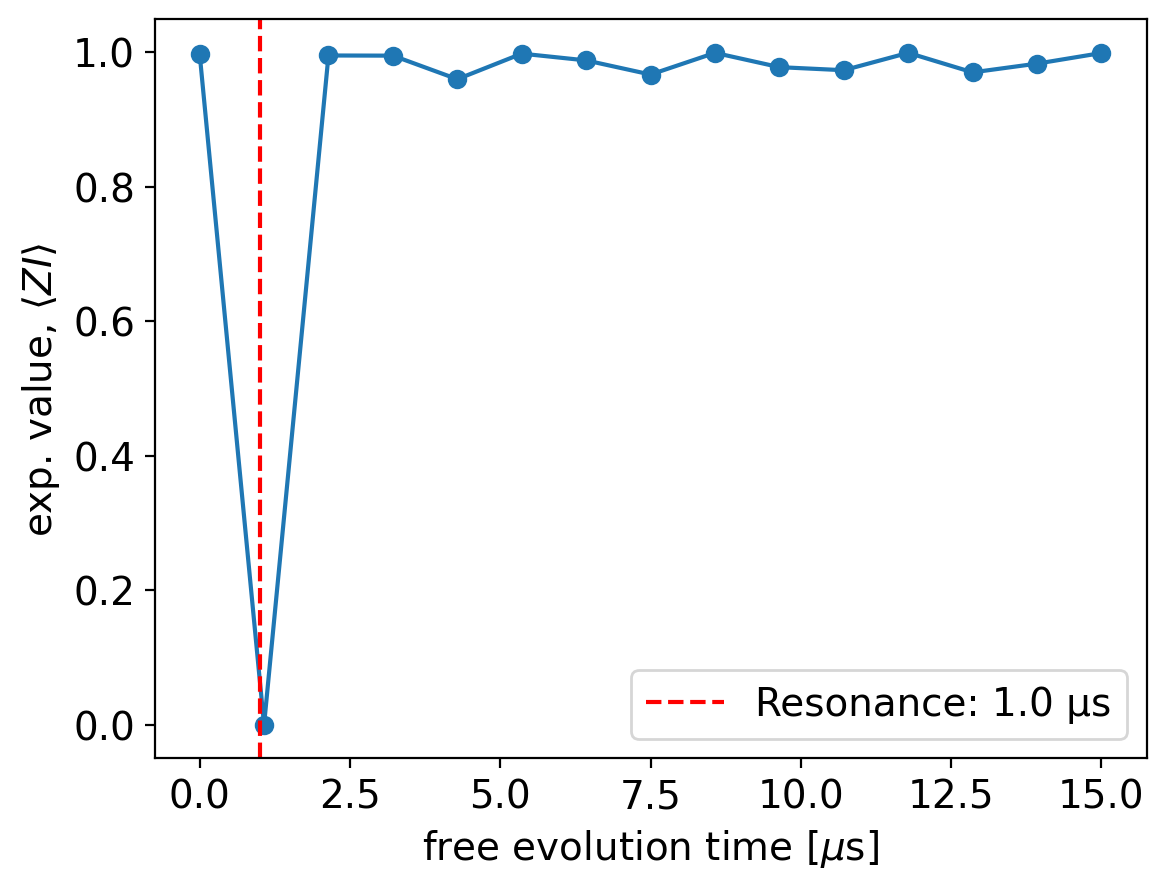

In [19]:
plt.plot(tau_values, signals, 'o-')
plt.axvline(tau_res, color='r', linestyle='--', label=f'Resonance: {tau_res:.1f} µs')
plt.legend()
plt.xlabel('free evolution time [$\mu$s]')
plt.ylabel('exp. value, $\\langle ZI \\rangle$')
plt.savefig("Measurement.pdf")